# Import Packages

# Load Dataset

In [0]:
import tensorflow as tf
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/Colab Notebooks"

 1.png						   input3.png
 butterfly					   knn.ipynb
 Cycle						   model.ipynb
 CycleGAN.ipynb					   Models.ipynb
 dataset					   Models_new.ipynb
'Generative Adversarial Networks Tutorial.ipynb'   output
 groundtruth1.png				   output1.png
 groundtruth2.png				   output2.png
 groundtruth3.png				   output3.png
 input						   PyTorch.ipynb
 input1.png					   Untitled.ipynb
 input2.png


In [0]:
def make_square(image):
    height, width = image.shape[0], image.shape[1]
    size = max(height, width)
    top = bottom = int((size - height) / 2)
    left = right = int((size - width) / 2)
    new_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value = [0, 0, 0])
    return new_image

In [0]:
cwd = "/content/drive/My Drive/Colab Notebooks"
path_input = cwd + "/input"
path_output = cwd + "/output"

In [6]:
# Original Dimensions for train
N = 832
image_width = 256
image_height = 256
channels = 3
ratio = 1

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)
dimension = (image_width, image_height)

i = 0

X = np.ndarray(shape = (N, image_height, image_width), dtype = np.float32)
Y = np.ndarray(shape = (N, image_height, image_width, channels), dtype = np.float32)

for filename in sorted(os.listdir(path_input)):
    if filename.endswith(".png"):
        image_input = cv2.imread(path_input + "/" + filename, cv2.IMREAD_UNCHANGED)
        image_input = np.array(np.asarray(image_input))
        
        image_output = cv2.imread(path_output + "/" + filename, cv2.IMREAD_UNCHANGED)
        image_output = np.array(np.asarray(image_output))
        
        X[i] = image_input
        Y[i] = image_output
        i += 1
        
        if i % 100 == 0:
            print(str(i) + " images are done!")
    else:
        continue

100 images are done!
200 images are done!
300 images are done!
400 images are done!
500 images are done!
600 images are done!
700 images are done!
800 images are done!


In [7]:
X = np.reshape(X, [N, image_height, image_width, 1])
print(X.shape)
copy_X = X
for i in range(channels - 1):
  copy_X = np.concatenate([X, copy_X], axis=3)
  
print(copy_X.shape)
X = copy_X
print(X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 13)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.125, random_state = 13)
print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))
print("X_train shape: {0}, X_val shape: {1}, X_test shape: {2}".format(X_train.shape, X_val.shape, X_test.shape))
print("Y_train shape: {0}, Y_val shape: {1}, Y_test shape: {2}".format(Y_train.shape, Y_val.shape, Y_test.shape))

(832, 256, 256, 1)
(832, 256, 256, 3)
(832, 256, 256, 3)
Train set size: 546, Val set size: 78, Test set size: 208
X_train shape: (546, 256, 256, 3), X_val shape: (78, 256, 256, 3), X_test shape: (208, 256, 256, 3)
Y_train shape: (546, 256, 256, 3), Y_val shape: (78, 256, 256, 3), Y_test shape: (208, 256, 256, 3)


In [0]:
def preprocess_image(img):
  """convert the image in range(0, 255) to (-1, 1)"""
  # return img.astype(np.float32) / 255 * 2 - 1
  return img / 255 * 2 - 1.0
  
def deprocess_image(img):
  """Undo preprocessing on an image and convert back to uint8."""
  return (img + 1) / 2 * 255
    
def rescale_image(img):
  '''ensure the pixel values of the image is in range (0, 255)'''
  vmin, vmax = tf.reduce_max(img), tf.reduce_min(img)
  img = (img - vmin) / (vmax - vmin)
  return img * 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


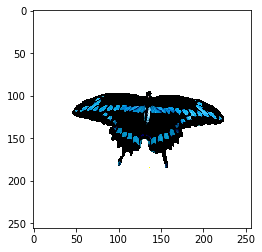

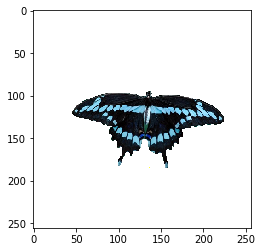

In [9]:
plt.imshow(preprocess_image(Y_train[0]))
plt.show()

plt.imshow(Y_train[0].astype(np.uint8))
plt.show()

#Network Architecture 

In [0]:
def discrim_conv(batch_input, out_channels, stride):
  initializer = tf.random_normal_initializer(0, 0.02)
  padded_input = tf.pad(batch_input, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="CONSTANT")
  return tf.layers.conv2d(padded_input, out_channels, kernel_size=4, strides=(stride, stride), padding="valid", kernel_initializer=initializer)

def gen_conv(batch_input, out_channels):
  # [batch, in_height, in_width, in_channels] => [batch, out_height, out_width, out_channels]
  initializer = tf.random_normal_initializer(0, 0.02)
  return tf.layers.conv2d(batch_input, out_channels, kernel_size=4, strides=(2, 2), padding="same", kernel_initializer=initializer)

def gen_deconv(batch_input, out_channels):
  # [batch, in_height, in_width, in_channels] => [batch, out_height, out_width, out_channels]
  initializer = tf.random_normal_initializer(0, 0.02)
  return tf.layers.conv2d_transpose(batch_input, out_channels, kernel_size=4, strides=(2, 2), padding="same", kernel_initializer=initializer)

def lrelu(x, a=0.01):
   with tf.name_scope("lrelu"):
      # adding these together creates the leak part and linear part
      # then cancels them out by subtracting/adding an absolute value term
      # leak: a*x/2 - a*abs(x)/2
      # linear: x/2 + abs(x)/2
      # this block looks like it has 2 inputs on the graph unless we do this
      x = tf.identity(x)
      return (0.5 * (1 + a)) * x + (0.5 * (1 - a)) * tf.abs(x)
    
def batchnorm(inputs):
  return tf.layers.batch_normalization(inputs, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=tf.random_normal_initializer(1.0, 0.02))


Discriminator


* 32 Filters,  4 x 4, Stride 1, Leaky ReLU(alpha = 0.2)
* Max pooling 2 x 2, Stride 2
* 64 Filters,  4 x 4, Stride 1, Leaky ReLU(alpha = 0.2)
* Max pooling 2 x 2, Stride 2
* 128 Filters,  4 x 4, Stride 1, Leaky ReLU(alpha = 0.2)
* Max pooling 2 x 2, Stride 2
* 256 Filters,  4 x 4, Stride 1, Leaky ReLU(alpha = 0.2)
* Max pooling 2 x 2, Stride 2
* 256 Filters,  4 x 4, Stride 1, Leaky ReLU(alpha = 0.2)
* Max pooling 2 x 2, Stride 2
* Flatten
* Fully Connected size 1024, Leaky ReLU(alpha = 0.01)
* Fully Connected size 1



In [0]:
def discriminator(color_image, edge_image, reuse=False):
  """
  color_image: [batch_size, image_height, image_width, 3] 
  edge_image: [batch_size, image_height, image_width, 3]
  
  return results in shape [batch_size, 1]
  """
  with tf.variable_scope('discriminator') as scope:
    if(reuse):
      tf.get_variable_scope().reuse_variables()
        # concatenate the input image with the edge image
    input_image = tf.concat([color_image, edge_image], axis=3)

    hidden_sizes = [32, 64, 128, 256, 256]
    
    # First Conv: [batch_size, 256, 256, 3] => [batch_szie, 128, 128, 32]
    conv1 = discrim_conv(color_image, hidden_sizes[0], stride=2)
    rectified1 = lrelu(conv1, 0.2)
    #maxpool1 = tf.nn.max_pool(rectified1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # Second Conv: [batch_size, 128, 128, 32] => [batch_szie, 64, 64, 64]
    conv2 = discrim_conv(rectified1, hidden_sizes[1], stride=2)
    bn2 = batchnorm(conv2)
    rectified2 = lrelu(bn2, 0.2)
    # maxpool2 = tf.nn.max_pool(rectified2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # Third Conv: [batch_size, 64, 64, 64] => [batch_szie, 32, 32, 128]
    conv3 = discrim_conv(rectified2, hidden_sizes[2], stride=2)
    bn3 = batchnorm(conv3)
    rectified3 = lrelu(bn3, 0.2)
    #maxpool3 = tf.nn.max_pool(rectified3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # Fourth Conv: [batch_size, 32, 32, 128] => [batch_size, 31, 31, 256]
    conv4 = discrim_conv(rectified3, hidden_sizes[3], stride=1)
    bn4 = batchnorm(conv4)
    rectified4 = lrelu(conv4, 0.2)
    #maxpool4 = tf.nn.max_pool(rectified4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    # Fifth Conv: [batch_size, 31, 31, 256] => [batch_szie, 30, 30, 1]
    conv5 = discrim_conv(rectified4, 1, stride=1)
    #rectified5 = lrelu(conv5, 0.2)
    #maxpool5 = tf.nn.max_pool(rectified5, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # Flatten: [batch_szie, 8, 8, 256] => [batch_size, 8*8*256]
    #flatten = tf.reshape(maxpool5, [-1, int(image_height/32) * int(image_width/32) * hidden_sizes[4]])
    
    # First FC: [batch_size, 8*8*256] => [batch_size, 1024]
    #fc1 = tf.layers.dense(inputs=flatten, units=1024, activation=lrelu)
    
    # Second FC: [batch_size, 1024] => [batch_size, 1]
    #fc2 = tf.layers.dense(inputs=fc1, units=1)
    
    #real_score = fc2[0]
    #fake_score = fc2[1]
    
    #prob = tf.exp(real_score) / (tf.exp(real_score) + tf.exp(fake_score))
    output = tf.sigmoid(conv5)
    return output

Generator


In [0]:
def generator(edge_image, reuse=False):
  """
  edge_image: [batch_size, image_height, image_width, 3]
  
  return the generated image in shape [batch_size, image_height, image_width, 3]
  """
  with tf.variable_scope('generator') as scope:
    if(reuse):
      tf.get_variable_scope().reuse_variables()

    hidden_sizes = [64, 64*2, 64*4, 64*8, 64*8, 64*8]  
    
    ''' downsample, 6 encode layer'''
    # encoder 1: [batch_size, 256, 256, 3] => [batch_szie, 128, 128, 64]
    conv1 = gen_conv(edge_image, hidden_sizes[0])
    encode_rectified1 = lrelu(conv1, 0.2)
    
    # encoder 2: [batch_size, 128, 128, 64] => [batch_szie, 64, 64, 64*2]
    conv2 = gen_conv(encode_rectified1, hidden_sizes[1])
    encode_bn2 = batchnorm(conv2)
    encode_rectified2 = lrelu(encode_bn2, 0.2)
    
    # encoder 3: [batch_size, 64, 64, 64*2] => [batch_szie, 32, 32, 64*4]
    conv3 = gen_conv(encode_rectified2, hidden_sizes[2])
    encode_bn3 = batchnorm(conv3)
    encode_rectified3 = lrelu(encode_bn3, 0.2)
    
    # encoder 4: [batch_size, 32, 32, 64*4] => [batch_szie, 16, 16, 64*8]
    conv4 = gen_conv(encode_rectified3, hidden_sizes[3])
    encode_bn4 = batchnorm(conv4)
    encode_rectified4 = lrelu(encode_bn4, 0.2)
    
    # encoder 5: [batch_size, 16, 16, 64*8] => [batch_szie, 8, 8, 64*8]
    conv5 = gen_conv(encode_rectified4, hidden_sizes[4])
    encode_bn5 = batchnorm(conv5)
    encode_rectified5 = lrelu(encode_bn5, 0.2)
    
    # encoder 6: [batch_size, 8, 8, 64*8] => [batch_szie, 4, 4, 64*8]
    conv6 = gen_conv(encode_rectified5, hidden_sizes[5])
    encode_bn6 = batchnorm(conv6)
    encode_rectified6 = lrelu(encode_bn6, 0.2)
    
    
    '''updample, 6 decode layers'''
    # decoder 6: [batch_szie, 4, 4, 64*8] => [batch_szie, 8, 8, 64*8]
    decode_rectified6 = tf.nn.relu(encode_rectified6)
    deconv6 = gen_deconv(decode_rectified6, hidden_sizes[4])
    decode_bn6 = batchnorm(deconv6)
    
    # decoder 5: [batch_szie, 8, 8, 64*8] => [batch_szie, 16, 16, 64*8]
    decode_rectified5 = tf.nn.relu(tf.concat([decode_bn6, encode_rectified5], axis=3))
    deconv5 = gen_deconv(decode_rectified5, hidden_sizes[3])
    decode_bn5 = batchnorm(deconv5)
    
    # decoder 4: [batch_szie, 16, 16, 64*8] => [batch_szie, 32, 32, 64*4]
    decode_rectified4 = tf.nn.relu(tf.concat([decode_bn5, encode_rectified4], axis=3))
    deconv4 = gen_deconv(decode_rectified4, hidden_sizes[2])
    decode_bn4 = batchnorm(deconv4)
    
    # decoder 3: [batch_szie, 32, 32, 64*4] => [batch_szie, 64, 64, 64*2]
    decode_rectified3 = tf.nn.relu(tf.concat([decode_bn4, encode_rectified3], axis=3))
    deconv3 = gen_deconv(decode_rectified3, hidden_sizes[1])
    decode_bn3 = batchnorm(deconv3)

    # decoder 2: [batch_szie, 64, 64, 64*2] => [batch_szie, 128, 128, 64]
    decode_rectified2 = tf.nn.relu(tf.concat([decode_bn3, encode_rectified2], axis=3))
    deconv2 = gen_deconv(decode_rectified2, hidden_sizes[0])
    decode_bn2 = batchnorm(deconv2)
    
    # decoder 1: [batch_szie, 128, 128, 64] => [batch_szie, 256, 256, 3]
    decode_rectified1 = tf.nn.relu(tf.concat([decode_bn2, encode_rectified1], axis=3))
    deconv1 = gen_deconv(decode_rectified1, channels)
    decode_bn1 = batchnorm(deconv1)
    
    return decode_bn1

Loss of GAN

In [0]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    
    # Target label vector for generator loss and used in discriminator loss.
    true_labels = tf.ones_like(logits_fake)
    
    # DISCRIMINATOR loss has 2 parts: how well it classifies real images and how well it
    # classifies fake images.
    real_image_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=true_labels)
    fake_image_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=1-true_labels)
    
    # Combine and average losses over the batch
    D_loss = real_image_loss + fake_image_loss 
    D_loss = tf.reduce_mean(D_loss)
    
    # GENERATOR is trying to make the discriminator output 1 for all its images.
    # So we use our target label vector of ones for computing generator loss.
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=true_labels)
    
    # Average generator loss over the batch.
    G_loss = tf.reduce_mean(G_loss)
    
    return D_loss, G_loss

In [0]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    
    return D_solver, G_solver

In [15]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 54

EPS = 1e-12
gan_weight = 1.0
l1_weight = 100.0
lr = 1e-3
beta1 = 0.5
# placeholder for images from the training dataset
real = tf.placeholder(tf.float32, [None, image_height, image_width, 3])
# edge images fed into our generator
edge = tf.placeholder(tf.float32, [None, image_height, image_width, 3])
# generated images
with tf.variable_scope("generator"):
  output = generator(edge)
    
# create two copies of discriminator, one for real pairs and one for fake pairs
# they share the same underlying variables
with tf.name_scope("real_discriminator"):
  with tf.variable_scope("discriminator"):
    # 2x [batch, height, width, channels] => [batch, 30, 30, 1]
    predict_real = discriminator(real, edge)
    
with tf.name_scope("fake_discriminator"):
  with tf.variable_scope("discriminator", reuse=True):
    # 2x [batch, height, width, channels] => [batch, 30, 30, 1]
    predict_fake = discriminator(output, edge)

with tf.name_scope("discriminator_loss"):
  # minimizing -tf.log will try to get inputs to 1
  # predict_real => 1
  # predict_fake => 0
  discrim_loss = tf.reduce_mean(-(tf.log(predict_real + EPS) + tf.log(1 - predict_fake + EPS)))
  
with tf.name_scope("generator_loss"):
  # predict_fake => 1
  # abs(targets - outputs) => 0
  gen_loss_GAN = tf.reduce_mean(-tf.log(predict_fake + EPS))
  gen_loss_L1 = tf.reduce_mean(tf.abs(real - output))
  gen_loss = gen_loss_GAN * gan_weight + gen_loss_L1 * l1_weight

with tf.name_scope("discriminator_train"):
  discrim_tvars = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]
  discrim_optim = tf.train.AdamOptimizer(lr, beta1)
  discrim_grads_and_vars = discrim_optim.compute_gradients(discrim_loss, var_list=discrim_tvars)
  discrim_train = discrim_optim.apply_gradients(discrim_grads_and_vars)  

with tf.name_scope("generator_train"):
  with tf.control_dependencies([discrim_train]):
    gen_tvars = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
    gen_optim = tf.train.AdamOptimizer(1e-2, beta1)
    gen_grads_and_vars = gen_optim.compute_gradients(gen_loss, var_list=gen_tvars)
    gen_train = gen_optim.apply_gradients(gen_grads_and_vars)
    
    
#ema = tf.train.ExponentialMovingAverage(decay=0.99)
#update_losses = ema.apply([discrim_loss, gen_loss_GAN, gen_loss_L1])

#global_step = tf.train.get_or_create_global_step()
#incr_global_step = tf.assign(global_step, global_step+1)

D_train_step = discrim_optim.minimize(discrim_loss, var_list=discrim_tvars)
G_train_step = gen_optim.minimize(gen_loss, var_list=gen_tvars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


epoch: 0, iteration: 0, dLoss: 1.4364789, gLoss: 22028.898 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


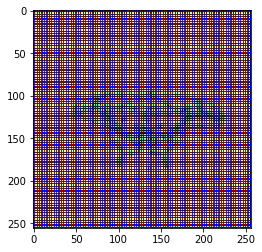


epoch: 5, iteration: 0, dLoss: 0.040531736, gLoss: 21982.826 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


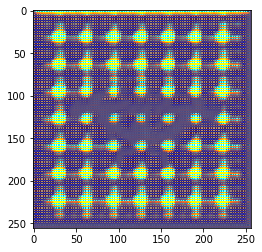


epoch: 10, iteration: 0, dLoss: 0.019628532, gLoss: 21933.82 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


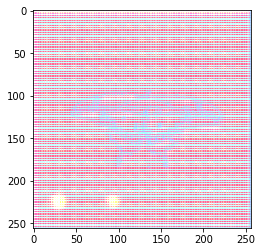


epoch: 15, iteration: 0, dLoss: 0.010268312, gLoss: 21886.014 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


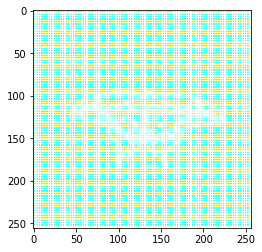


epoch: 20, iteration: 0, dLoss: 7.2560225, gLoss: 21838.523 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


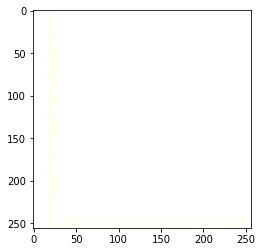


epoch: 25, iteration: 0, dLoss: 5.4860635, gLoss: 21784.395 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


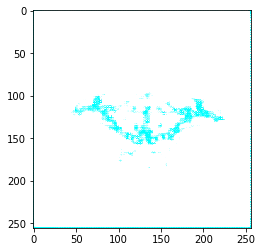


epoch: 30, iteration: 0, dLoss: 0.036087923, gLoss: 21738.107 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


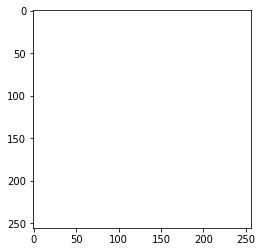


epoch: 35, iteration: 0, dLoss: 0.007293061, gLoss: 21693.955 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


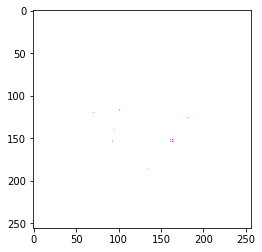


epoch: 40, iteration: 0, dLoss: 1.8807569, gLoss: 21631.982 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


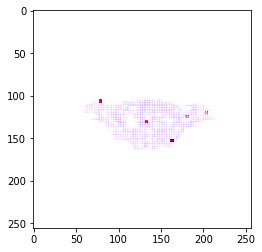


epoch: 45, iteration: 0, dLoss: 1.878967, gLoss: 21584.605 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


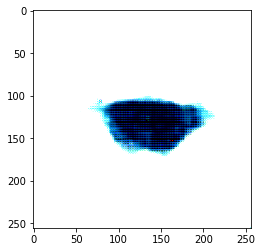

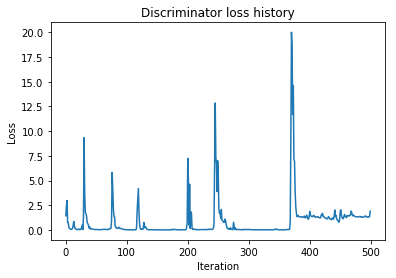

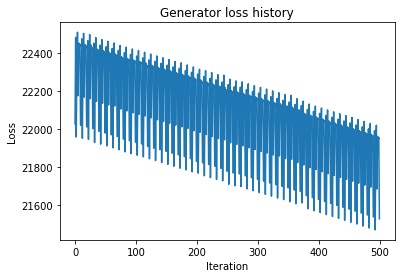

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
epoch = 50

dis_loss_history = []
gen_loss_history = []

for i in range(epoch):
  for j in range(int(540 / batch_size)):
    #Update the discriminator
    edge_batch = (X_train[j * batch_size : (j+1) * batch_size])
    real_batch = (Y_train[j * batch_size : (j+1) * batch_size])
    # run a batch of data through the network
    _, D_loss_curr = sess.run([D_train_step, discrim_loss], feed_dict={real: real_batch, edge: edge_batch})
    _, G_loss_curr = sess.run([G_train_step, gen_loss], feed_dict= {real: real_batch, edge: edge_batch})
    dis_loss_history.append(D_loss_curr)
    gen_loss_history.append(G_loss_curr)
    
    if i % 5 == 0 and j == 0:
      print("epoch: %s, iteration: %s, dLoss: %s, gLoss: %s " % (i, j, D_loss_curr, G_loss_curr))
      samples = sess.run(output, feed_dict= {edge: edge_batch})
      #fig = plt.imshow(deprocess_image(samples[0], rescale=True))
      fig = plt.imshow((samples[0]))
      plt.show()
      print()

plt.plot(dis_loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Discriminator loss history')
plt.show()

plt.plot(gen_loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator loss history')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


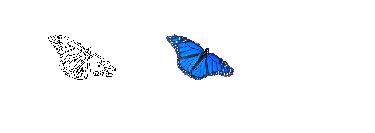

<Figure size 432x288 with 0 Axes>

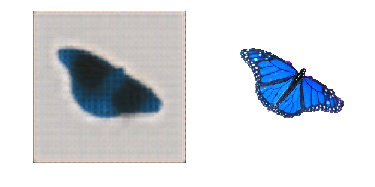

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
batch_size = 1
index = 30
path = '/content/drive/My Drive/Colab Notebooks'
edge_batch = X_train[index]
edge_batch = np.reshape(edge_batch, [batch_size, image_height, image_width, 3])
my_i = sess.run(output, feed_dict= {edge: edge_batch})
my_i = my_i.squeeze()

img_min = my_i.min()
img_max = my_i.max()
my_i = (my_i - img_min) / (img_max - img_min) * 255
'''1'''
f, axarr = plt.subplots(1,3)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

axarr[0].imshow(X_train[index].astype(np.uint8))
axarr[1].imshow(Y_train[index].astype(np.uint8))
axarr[2].imshow(my_i)
plt.show()
plt.figure()


cv2.imwrite(path + "/" + "input1.png", X_train[index])
cv2.imwrite(path + "/" + "groundtruth1.png", Y_train[index])
cv2.imwrite(path + "/" + "output1.png", my_i)
'''2'''
img_min = my_i.min()
img_max = my_i.max()
my_i = (my_i - img_min) / (img_max - img_min) * 255
f, axarr = plt.subplots(1,2)
axarr[0].axis('off')
axarr[1].axis('off')

axarr[0].imshow((my_i.astype(np.uint8)))
axarr[1].imshow(Y_train[index].astype(np.uint8))
plt.show()
plt.figure()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


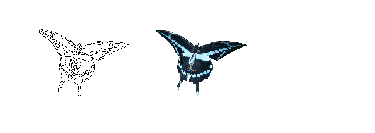

True

<Figure size 432x288 with 0 Axes>

In [18]:
index = 1
edge_batch = X_train[index]
edge_batch = np.reshape(edge_batch, [batch_size, image_height, image_width, 3])
my_i = sess.run(output, feed_dict= {edge: edge_batch})
my_i = my_i.squeeze()

img_min = my_i.min()
img_max = my_i.max()
my_i = (my_i - img_min) / (img_max - img_min) * 255
'''1'''
f, axarr = plt.subplots(1,3)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

axarr[0].imshow(X_train[index].astype(np.uint8))
axarr[1].imshow(Y_train[index].astype(np.uint8))
axarr[2].imshow(my_i)
plt.show()
plt.figure()


cv2.imwrite(path + "/" + "input2.png", X_train[index])
cv2.imwrite(path + "/" + "groundtruth2.png", Y_train[index])
cv2.imwrite(path + "/" + "output2.png", my_i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


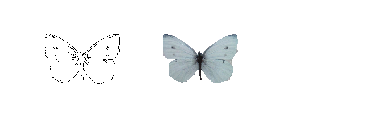

True

<Figure size 432x288 with 0 Axes>

In [19]:
index = 2
edge_batch = X_train[index]
edge_batch = np.reshape(edge_batch, [batch_size, image_height, image_width, 3])
my_i = sess.run(output, feed_dict= {edge: edge_batch})
my_i = my_i.squeeze()

img_min = my_i.min()
img_max = my_i.max()
my_i = (my_i - img_min) / (img_max - img_min) * 255
'''1'''
f, axarr = plt.subplots(1,3)
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

axarr[0].imshow(X_train[index].astype(np.uint8))
axarr[1].imshow(Y_train[index].astype(np.uint8))
axarr[2].imshow(my_i)
plt.show()
plt.figure()


cv2.imwrite(path + "/" + "input3.png", X_train[index])
cv2.imwrite(path + "/" + "groundtruth3.png", Y_train[index])
cv2.imwrite(path + "/" + "output3.png", my_i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


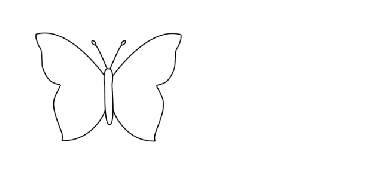

True

<Figure size 432x288 with 0 Axes>

In [23]:
path = '/content/drive/My Drive/Colab Notebooks/Cycle/datasets/butterfly_test/testA'
path_output = '/content/drive/My Drive/Colab Notebooks/Cycle/datasets'
input_image = cv2.imread(path + "/" + 'exp1.png')
edge_batch = np.array(input_image)
edge_batch = np.reshape(edge_batch, [batch_size, image_height, image_width, 3])
my_i = sess.run(output, feed_dict= {edge: edge_batch})
my_i = my_i.squeeze()

img_min = my_i.min()
img_max = my_i.max()
my_i = (my_i - img_min) / (img_max - img_min) * 255
'''1'''
f, axarr = plt.subplots(1,2)
axarr[0].axis('off')
axarr[1].axis('off')

axarr[0].imshow(input_image.astype(np.uint8))
axarr[1].imshow(my_i)
plt.show()
plt.figure()


cv2.imwrite(path_output + "/" + "exp1_result.png", my_i)